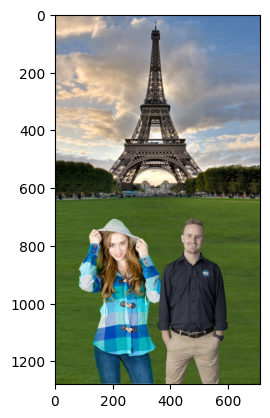

In [20]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Please DO NOT add any additional imports to this notebook
# Functionality using libraries other than those listed above will not be graded


def process_image(BG: np.ndarray, I1: np.ndarray, I2: np.ndarray) -> np.ndarray:
    """
        Processes the background image (BG) and overlays two images (I1 and I2).
        
        This function extracts the people from two input images (I1, I2),
        resizes them proportionally to fit the background image (BG), and positions them near the
        bottom of the background. It uses dynamic scaling and placement based on the dimensions of 
        the background image to ensure adaptability for various image sizes.

        Steps:
        1. Green-Screen Removal:
        - Detects green regions in each input image using HSV color segmentation.
        - Refines the mask to remove noise and accurately detect the green box enclosing the person.
        - Rotates the image based on the green box orientation and crops the person.
        - Converts the cropped image to a transparent format with an alpha channel.

        2. Scaling and Resizing:
        - Resizes the extracted transparent images proportionally to half the height of the background
            while maintaining their aspect ratio.

        3. Positioning:
        - Dynamically calculates padding and positions the resized images near the bottom of the 
            background image, with one image on the left and the other on the right.

        4. Overlaying with Transparency:
        - Blends the resized images onto the background using their alpha channel for transparency.

        Notes:
        - Assumes the input images (I1 and I2) have a prominent green background for proper segmentation.
        - The function is robust to varying background and input image sizes.
    """
    
    def getTransparentPerson(I):
        # Convert to HSV and create a mask for the green color
        hsv = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)
        lower_green = np.array([35, 50, 50])
        upper_green = np.array([85, 255, 255])
        mask = cv2.inRange(hsv, lower_green, upper_green)
        
        # Refine the mask to remove noise
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   # Remove small noise
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Close gaps in the mask

        
        # Find contours of the green regions
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print("No green box found in the image.")
            return
        
        # Get the largest contour and calculate the minimum area rectangle
        largest_contour = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(largest_contour)
        angle = rect[-1]
        if angle < -45:
            angle += 90
        elif angle > 45:
            angle -= 90
        
        # Rotate the image based on the angle of the green box
        (h, w) = I.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_image = cv2.warpAffine(I, rotation_matrix, (w, h))
        rotated_mask = cv2.warpAffine(mask, rotation_matrix, (w, h))
        
        # Crop the bounding box area of the green box
        x, y, w, h = cv2.boundingRect(rotated_mask)
        cropped = rotated_image[y:y+h, x:x+w]
        cropped_mask = rotated_mask[y:y+h, x:x+w]
        
        # Refine the cropped mask to remove border artifacts
        cropped_mask = cv2.morphologyEx(cropped_mask, cv2.MORPH_OPEN, kernel)   # Remove noise
        cropped_mask = cv2.morphologyEx(cropped_mask, cv2.MORPH_CLOSE, kernel)  # Close gaps
        
        # Invert the mask and apply it to the cropped image
        cropped_mask_inv = cv2.bitwise_not(cropped_mask)
        cropped_alpha = cv2.cvtColor(cropped, cv2.COLOR_BGR2BGRA)
        cropped_alpha[:, :, 3] = cropped_mask_inv
        
        return cropped_alpha
    
    
    transparent_I1 = getTransparentPerson(I1)
    transparent_I2 = getTransparentPerson(I2)
    

    bg_h, bg_w = BG.shape[:2]
    i1_h, i1_w = transparent_I1.shape[:2]
    i2_h, i2_w = transparent_I2.shape[:2]
    
    scale_factor_1 = 0.50 * bg_h / i1_h
    scale_factor_2 = 0.50 * bg_h / i2_h
    
    resized_I1 = cv2.resize(transparent_I1, (int(i1_w * scale_factor_1), int(i1_h * scale_factor_1)), interpolation=cv2.INTER_AREA)
    resized_I2 = cv2.resize(transparent_I2, (int(i2_w * scale_factor_2), int(i2_h * scale_factor_2)), interpolation=cv2.INTER_AREA)
    
    padding_x = int(0.0001 * bg_w)
    padding_y = int(0.0001* bg_h)

    y_offset1 = bg_h - resized_I1.shape[0] - padding_y
    y_offset2 = bg_h - resized_I2.shape[0] - padding_y
    x_offset1 = padding_x
    x_offset2 = bg_w - resized_I2.shape[1] - padding_x
    
    for c in range(3):
        BG[y_offset1:y_offset1+resized_I1.shape[0], x_offset1:x_offset1+resized_I1.shape[1], c] = \
            BG[y_offset1:y_offset1+resized_I1.shape[0], x_offset1:x_offset1+resized_I1.shape[1], c] * \
            (1 - resized_I1[:, :, 3] / 255.0) + resized_I1[:, :, c] * (resized_I1[:, :, 3] / 255.0)
    
    for c in range(3):
        BG[y_offset2:y_offset2+resized_I2.shape[0], x_offset2:x_offset2+resized_I2.shape[1], c] = \
            BG[y_offset2:y_offset2+resized_I2.shape[0], x_offset2:x_offset2+resized_I2.shape[1], c] * \
            (1 - resized_I2[:, :, 3] / 255.0) + resized_I2[:, :, c] * (resized_I2[:, :, 3] / 255.0)
    
    BG = cv2.cvtColor(BG, cv2.COLOR_BGRA2RGB)
    
    return BG

# Please DO NOT change any of the code below. All modifications to this template should
# occur inside the **process_image** function


BG = cv2.imread('./background.jpg')
I1 = cv2.imread('./person1.jpg')
I2 = cv2.imread('./person2.jpg')

merged = process_image(BG, I1, I2)

plt.imshow(merged)


[[[ 341  198]]

 [[3994  197]]

 [[3995 5067]]

 [[ 342 5067]]]
Transparent image saved at cropped_with_transparency.png


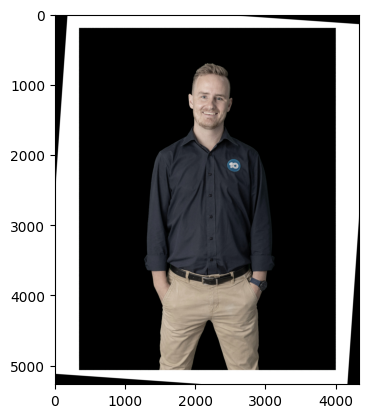

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def getPixels(I: np.ndarray):
    I_hsv = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)
    
    # Define green color range
    lower_green = np.array([35, 50, 50])
    upper_green = np.array([85, 255, 255])

    # Create a mask to extract green areas
    mask = cv2.inRange(I_hsv, lower_green, upper_green)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours are found
    if contours:
        # Assume the largest contour is the green box
        largest_contour = max(contours, key=cv2.contourArea)

        # Get the minimum area rectangle for the largest contour
        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

        # Calculate the angle of rotation
        angle = rect[-1]
        if angle < -45:
            angle = angle + 90  # Adjust the angle for stability
        elif angle > 45:
            angle = angle - 90

        # Get the rotation matrix and rotate the image
        (h, w) = I.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        I_rotated = cv2.warpAffine(I, rotation_matrix, (w, h))

        # Convert I_rotated to HSV and create mask for green
        hsv1 = cv2.cvtColor(I_rotated, cv2.COLOR_BGR2HSV)
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        mask = cv2.inRange(hsv1, lower_green, upper_green)

        # Use morphological operations to clean up the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask_inv = cv2.bitwise_not(mask)

        # Apply the mask to remove the background
        I_no_bg = cv2.bitwise_and(I_rotated, I_rotated, mask=mask_inv)

        # Convert I_no_bg to RGB
        I_no_bg = cv2.cvtColor(I_no_bg, cv2.COLOR_BGR2RGB)
        
        # Crop the image to the bounding box of the green box
        x, y, w, h = cv2.boundingRect(largest_contour)
        I_cropped = I_no_bg[y:y+h, x:x+w]
        
        # Add transparency to the cropped image
        I_cropped_alpha = cv2.cvtColor(I_cropped, cv2.COLOR_RGB2RGBA)
        mask_cropped = mask_inv[y:y+h, x:x+w]
        I_cropped_alpha[:, :, 3] = mask_cropped


        I_cropped_alpha = cv2.cvtColor(I_cropped_alpha, cv2.COLOR_RGBA2BGRA)
    
        # Bottom_left, top_right
    
        # Rotate the box to fit the rotated image
        box = np.array(box)
        box = box.reshape(-1, 1, 2)
        box_rotated = cv2.transform(box, rotation_matrix)
        box_rotated = np.int32(box_rotated)
        
        # Draw the rotated bounding box on the image
        I_rotated_box = I_no_bg.copy()
        
        # cv2.drawContours(I_rotated_box, [box_rotated], 0, (0, 255, 0), 15)
        plt.imshow(I_rotated_box)
 
 
        # Crop where the box is
        print(box_rotated)
        
        # Make an image with only with what is inside the box
        I_cropped_box = I_rotated_box.copy()
        
        # Get the bounding box of the rotated box
        x, y, w, h = cv2.boundingRect(box_rotated)
        
        # Crop the image to the bounding box of the rotated box
        I_cropped_box = I_cropped_box[y:y+h, x:x+w]
        
        # Add transparency to the cropped image
        I_cropped_box_alpha = cv2.cvtColor(I_cropped_box, cv2.COLOR_RGB2RGBA)
        mask_cropped = mask_inv[y:y+h, x:x+w]
        I_cropped_box_alpha[:, :, 3] = mask_cropped
        
        I_cropped_box_alpha = cv2.cvtColor(I_cropped_box_alpha, cv2.COLOR_RGBA2BGRA)
        
    
        # Save the transparent image
        output_path = 'cropped_with_transparency.png'
        cv2.imwrite(output_path, I_cropped_box_alpha)
        print(f"Transparent image saved at {output_path}")

    else:
        print("No green box found in the image.")

# Load the image
I = cv2.imread('person2.jpg')

getPixels(I)

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def getTransparentPerson(I):
    
    # Convert to HSV and create a mask for the green color
    hsv = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)
    lower_green = np.array([35, 50, 50])
    upper_green = np.array([85, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    # Refine the mask to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   # Remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Close gaps in the mask

    
    # Find contours of the green regions
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No green box found in the image.")
        return
    
    # Get the largest contour and calculate the minimum area rectangle
    largest_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    angle = rect[-1]
    if angle < -45:
        angle += 90
    elif angle > 45:
        angle -= 90
    
    # Rotate the image based on the angle of the green box
    (h, w) = I.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(I, rotation_matrix, (w, h))
    rotated_mask = cv2.warpAffine(mask, rotation_matrix, (w, h))
    
    # Crop the bounding box area of the green box
    x, y, w, h = cv2.boundingRect(rotated_mask)
    cropped = rotated_image[y:y+h, x:x+w]
    cropped_mask = rotated_mask[y:y+h, x:x+w]
    
    # Refine the cropped mask to remove border artifacts
    cropped_mask = cv2.morphologyEx(cropped_mask, cv2.MORPH_OPEN, kernel)   # Remove noise
    cropped_mask = cv2.morphologyEx(cropped_mask, cv2.MORPH_CLOSE, kernel)  # Close gaps
    
    # Invert the mask and apply it to the cropped image
    cropped_mask_inv = cv2.bitwise_not(cropped_mask)
    cropped_alpha = cv2.cvtColor(cropped, cv2.COLOR_BGR2BGRA)
    cropped_alpha[:, :, 3] = cropped_mask_inv
    
    return cropped_alpha

# Load the image
I = cv2.imread('person2.jpg')

# Process the image
output = getTransparentPerson(I)

# Save the output image
output_path = 'output.png'
cv2.imwrite(output_path, output)
print(f"Output image saved at {output_path}")




Output image saved at output.png


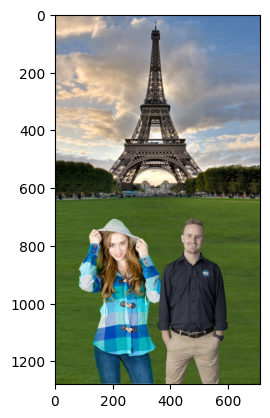

In [19]:
# Please DO NOT add any additional imports to this notebook
# Functionality using libraries other than those listed above will not be graded
import cv2
import numpy as np
import matplotlib.pyplot as plt




def process_image(BG: np.ndarray, I1: np.ndarray, I2: np.ndarray) -> np.ndarray:
    """
        Processes the background image (BG) and overlays two images (I1 and I2).
        
        This function extracts the people from two input images (I1, I2),
        resizes them proportionally to fit the background image (BG), and positions them near the
        bottom of the background. It uses dynamic scaling and placement based on the dimensions of 
        the background image to ensure adaptability for various image sizes.

        Steps:
        1. Green-Screen Removal:
        - Detects green regions in each input image using HSV color segmentation.
        - Refines the mask to remove noise and accurately detect the green box enclosing the person.
        - Rotates the image based on the green box orientation and crops the person.
        - Converts the cropped image to a transparent format with an alpha channel.

        2. Scaling and Resizing:
        - Resizes the extracted transparent images proportionally to half the height of the background
            while maintaining their aspect ratio.

        3. Positioning:
        - Dynamically calculates padding and positions the resized images near the bottom of the 
            background image, with one image on the left and the other on the right.

        4. Overlaying with Transparency:
        - Blends the resized images onto the background using their alpha channel for transparency.

        Notes:
        - Assumes the input images (I1 and I2) have a prominent green background for proper segmentation.
        - The function is robust to varying background and input image sizes.
    """
    
    def getTransparentPerson(I):
        # Convert to HSV and create a mask for the green color
        hsv = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)
        lower_green = np.array([35, 50, 50])
        upper_green = np.array([85, 255, 255])
        mask = cv2.inRange(hsv, lower_green, upper_green)
        
        # Refine the mask to remove noise
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   # Remove small noise
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Close gaps in the mask

        
        # Find contours of the green regions
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print("No green box found in the image.")
            return
        
        # Get the largest contour and calculate the minimum area rectangle
        largest_contour = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(largest_contour)
        angle = rect[-1]
        if angle < -45:
            angle += 90
        elif angle > 45:
            angle -= 90
        
        # Rotate the image based on the angle of the green box
        (h, w) = I.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_image = cv2.warpAffine(I, rotation_matrix, (w, h))
        rotated_mask = cv2.warpAffine(mask, rotation_matrix, (w, h))
        
        # Crop the bounding box area of the green box
        x, y, w, h = cv2.boundingRect(rotated_mask)
        cropped = rotated_image[y:y+h, x:x+w]
        cropped_mask = rotated_mask[y:y+h, x:x+w]
        
        # Refine the cropped mask to remove border artifacts
        cropped_mask = cv2.morphologyEx(cropped_mask, cv2.MORPH_OPEN, kernel)   # Remove noise
        cropped_mask = cv2.morphologyEx(cropped_mask, cv2.MORPH_CLOSE, kernel)  # Close gaps
        
        # Invert the mask and apply it to the cropped image
        cropped_mask_inv = cv2.bitwise_not(cropped_mask)
        cropped_alpha = cv2.cvtColor(cropped, cv2.COLOR_BGR2BGRA)
        cropped_alpha[:, :, 3] = cropped_mask_inv
        
        return cropped_alpha
    
    
    transparent_I1 = getTransparentPerson(I1)
    transparent_I2 = getTransparentPerson(I2)
    

    bg_h, bg_w = BG.shape[:2]
    i1_h, i1_w = transparent_I1.shape[:2]
    i2_h, i2_w = transparent_I2.shape[:2]
    
    scale_factor_1 = 0.50 * bg_h / i1_h
    scale_factor_2 = 0.50 * bg_h / i2_h
    
    resized_I1 = cv2.resize(transparent_I1, (int(i1_w * scale_factor_1), int(i1_h * scale_factor_1)), interpolation=cv2.INTER_AREA)
    resized_I2 = cv2.resize(transparent_I2, (int(i2_w * scale_factor_2), int(i2_h * scale_factor_2)), interpolation=cv2.INTER_AREA)
    
    padding_x = int(0.0001 * bg_w)
    padding_y = int(0.0001* bg_h)

    y_offset1 = bg_h - resized_I1.shape[0] - padding_y
    y_offset2 = bg_h - resized_I2.shape[0] - padding_y
    x_offset1 = padding_x
    x_offset2 = bg_w - resized_I2.shape[1] - padding_x
    
    for c in range(3):
        BG[y_offset1:y_offset1+resized_I1.shape[0], x_offset1:x_offset1+resized_I1.shape[1], c] = \
            BG[y_offset1:y_offset1+resized_I1.shape[0], x_offset1:x_offset1+resized_I1.shape[1], c] * \
            (1 - resized_I1[:, :, 3] / 255.0) + resized_I1[:, :, c] * (resized_I1[:, :, 3] / 255.0)
    
    for c in range(3):
        BG[y_offset2:y_offset2+resized_I2.shape[0], x_offset2:x_offset2+resized_I2.shape[1], c] = \
            BG[y_offset2:y_offset2+resized_I2.shape[0], x_offset2:x_offset2+resized_I2.shape[1], c] * \
            (1 - resized_I2[:, :, 3] / 255.0) + resized_I2[:, :, c] * (resized_I2[:, :, 3] / 255.0)
    
    BG = cv2.cvtColor(BG, cv2.COLOR_BGRA2RGB)
    
    return BG




# Please DO NOT change any of the code below. All modifications to this template should
# occur inside the **process_image** function


BG = cv2.imread('./background.jpg')
I1 = cv2.imread('./person1.jpg')
I2 = cv2.imread('./person2.jpg')

merged = process_image(BG, I1, I2)

plt.imshow(merged)
